# Image Captioning
Task: Generate Image Captions<br>
Dataset: VizWiz-Captions dataset<br>
Challenge [Link](https://vizwiz.org/tasks-and-datasets/image-captioning/)

It is a proposed approach for image captioning, on further improvements it might give best results on this dataset.

##Data Downloading

In [1]:
# Training data
!wget --header="Host: ivc.ischool.utexas.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.122 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Referer: https://vizwiz.org/tasks-and-datasets/image-captioning/" "https://ivc.ischool.utexas.edu/VizWiz_final/images/train.zip" -c -O 'train.zip'

--2020-05-08 14:58:03--  https://ivc.ischool.utexas.edu/VizWiz_final/images/train.zip
Resolving ivc.ischool.utexas.edu (ivc.ischool.utexas.edu)... 146.6.168.124
Connecting to ivc.ischool.utexas.edu (ivc.ischool.utexas.edu)|146.6.168.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11298421598 (11G) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>]  10.52G  37.9MB/s    in 4m 10s  

2020-05-08 15:02:13 (43.2 MB/s) - ‘train.zip’ saved [11298421598/11298421598]



In [2]:
# validation data
!wget --header="Host: ivc.ischool.utexas.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.122 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Referer: https://vizwiz.org/tasks-and-datasets/image-captioning/" "https://ivc.ischool.utexas.edu/VizWiz_final/images/val.zip" -c -O 'val.zip'

--2020-05-08 13:05:36--  https://ivc.ischool.utexas.edu/VizWiz_final/images/val.zip
Resolving ivc.ischool.utexas.edu (ivc.ischool.utexas.edu)... 146.6.168.124
Connecting to ivc.ischool.utexas.edu (ivc.ischool.utexas.edu)|146.6.168.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3488913457 (3.2G) [application/zip]
Saving to: ‘val.zip’

val.zip             100%[===================>]   3.25G  36.7MB/s    in 83s     

2020-05-08 13:06:59 (40.3 MB/s) - ‘val.zip’ saved [3488913457/3488913457]



In [3]:
# Annotations
!wget --header="Host: ivc.ischool.utexas.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" "https://ivc.ischool.utexas.edu/VizWiz_final/caption/annotations.zip" -c -O 'annotations.zip'

--2020-05-08 13:07:08--  https://ivc.ischool.utexas.edu/VizWiz_final/caption/annotations.zip
Resolving ivc.ischool.utexas.edu (ivc.ischool.utexas.edu)... 146.6.168.124
Connecting to ivc.ischool.utexas.edu (ivc.ischool.utexas.edu)|146.6.168.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4509069 (4.3M) [application/zip]
Saving to: ‘annotations.zip’

annotations.zip     100%[===================>]   4.30M  14.8MB/s    in 0.3s    

2020-05-08 13:07:09 (14.8 MB/s) - ‘annotations.zip’ saved [4509069/4509069]



In [0]:
from zipfile import ZipFile

# training data path
train_zip = '/content/train.zip'
with ZipFile( train_zip ) as z:
  z.extractall()

# validation data path
valid_zip = '/content/val.zip'
with ZipFile( valid_zip ) as z:
  z.extractall()

# annotation data path
annotation_pth = '/content/annotations.zip'
with ZipFile( annotation_pth ) as z:
  z.extractall()

In [3]:
import os
import json
import re
import math
import numpy as np
import random
import time
import collections
import warnings
warnings.filterwarnings(action="ignore")
from collections import defaultdict

import torch
import torch.nn as nn
from torch import optim
from torch.nn import functional as F
import torchvision
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

from torchtext import vocab
from keras.preprocessing.sequence import pad_sequences

from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

Using TensorFlow backend.


## Data Preprocessing

In [0]:
class VizWizDataset(Dataset):
  """
     Custom class to create dataset of images and captions from json(annotation) file
    Args:
      annotation (str): path to the annotation of data
      size (int, int): size of the image to be resized
      path (str): path to the downloaded images
      ignore_rejected (bool): [default:True] to reject, captions with is_rejected flag as true, in dataset
      ignore_precanned (bool): [default:True] to reject, captions with is_precanned flag as true, in dataset
      text_detected (bool): [default:True] to accept captions only with 'text_detected' flag as true
    """

  def __init__(self, annotation, size, path, ignore_rejected = True, ignore_precanned = True, text_detected = True):
    self.PATH = path
    self.ignore_rejected = ignore_rejected
    self.ignore_precanned = ignore_precanned
    self.text_detected = text_detected

    # dict with img_id as key and value is list containing caption, 'is_precanned', 'is_rejected', 'text_detected'
    self.caps_dict = defaultdict(list)
    self.caps_dict_final = defaultdict(list)

    # list of images for which 'text_Detected' == True in image annotation
    self.imgs = []
    self.loadAnnotations(annotation)

    # transforms for image data
    self.tfms = transforms.Compose([transforms.Resize(size),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    
    # word counter dictionary with key as word and value as no. of word occurance
    self.count = collections.Counter()
    # word vocabulary
    self.word_vocab = None
    self.tokenize()
    
  def loadAnnotations(self, annotation):
    """
    function to load annotation data and update the captions of an image in dict
    and update the imgs list
    """
    # loading annotation file
    with open(annotation) as file:
      data = json.load(file)

    # update captions of corresponding image
    for annot in data['annotations']:
      if not ((self.ignore_rejected and annot['is_rejected']) or (self.ignore_precanned and annot['is_precanned'])):
        self.caps_dict[annot['image_id']].append(annot)

    # update imgs list
    for img in data['images']:
      if self.caps_dict[img['id']] and (img['text_detected'] and self.text_detected):
        self.imgs.append(img)

  def tokenize(self):
    """
    """
    PUNCTUATIONS = r'[!()\-[\]{};:"\,<>/?@#$%^&.*_~]'
    # special tokens
    START_TOKEN = '<sos>'
    END_TOKEN = '<eos>'
    PAD_TOKEN = '<pad>'
    UNK_TOKEN = '<unk>'

    # list of all captions in dataset for vocabulary
    text_corpus = []
    for key, value in self.caps_dict.items():
      for item in value:
        text = re.sub(PUNCTUATIONS, "", item['caption'])
        tokens = (START_TOKEN + ' ' + text.lower() + ' ' + END_TOKEN)
        self.caps_dict_final[str(key)].append(tokens)
        text_corpus.append(tokens.split())

    # counting words' frequency
    for seq in text_corpus:
      for word in seq:
        self.count[word]+=1

    # creating vocabulary of words
    self.word_vocab = vocab.Vocab(self.count,
                            max_size=7000,
                            min_freq=2,
                            specials=[PAD_TOKEN, START_TOKEN, END_TOKEN, UNK_TOKEN])
    
    
  def __len__(self):
    """Returns length of dataset"""
    # number of images
    return len(self.imgs)

  def __getitem__(self, idx):
    img_dict = self.imgs[idx]
    # image id
    id = img_dict['id']
    # load image from path
    img = Image.open(os.path.join(self.PATH, img_dict['file_name']))
    # applying transforms
    img = self.tfms(img)
    captions = [caption for caption in self.caps_dict_final[str(id)]]

    return img, captions

In [0]:
START_TOKEN = '<sos>'
END_TOKEN = '<eos>'
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'

cnt = collections.Counter()
# vocabulary of all the words present in the train, valid captions
global global_vocab
global_vocab = vocab.Vocab(cnt,
                           max_size=10000,
                           min_freq=2,
                           specials=[PAD_TOKEN, START_TOKEN, END_TOKEN, UNK_TOKEN])

if torch.cuda.is_available():
  device='cuda'
else:
  device='cpu'

In [0]:
# path to validation annotatations file
valid_ann = '/content/annotations/val.json'

# image size required for the model
size = (224, 224)

# path to validation images 
valid_path = '/content/val/'

#path to training annotations file
train_ann = '/content/annotations/train.json'
# path to training images
train_path = '/content/train/'

In [0]:
def cap_collate_fn(batch):
  '''
  -> Custom collate function for torch DataLoader
    
    Returns batch (imgs, capts)
  '''
  imgs = [img for img,_ in batch]
  captions = [cap for _,cap in batch]
  # number of words in every sentence(caption) in a batch
  lens = []
  for item in captions:
    for cap in item:
      lens.append(len(cap.split(' ')))
  # max length of any sequence(caption) in the batch
  # max_len = np.percentile(lens, 100)
  max_len = max(lens)

  min_caps = min([len(caps) for _, caps in batch])
  capts = []
  # max_len = 128
  for idx in range(min_caps):
    items=[]
    for cap in captions:
      tokens = cap[idx].split(' ')
      tok_ids = [global_vocab.stoi[token] if global_vocab.stoi[token] else global_vocab.stoi['<unk>'] for token in tokens]
      items.append(tok_ids)
    capts.append(pad_sequences(items, maxlen=max_len, padding='post', truncating='post', value=0))
    # capts = pad_sequences(capts, maxlen=max_len, padding='post', truncating='post', value=0)
  return torch.stack(imgs), torch.LongTensor(capts)

In [0]:
bs = 5

train_d = VizWizDataset(train_ann, size, train_path)
valid_d = VizWizDataset(valid_ann, size, valid_path)

# update global vocab
global_vocab.extend(train_d.word_vocab)
global_vocab.extend(valid_d.word_vocab)

trainloader = DataLoader(train_d, batch_size= bs, shuffle=True, collate_fn=cap_collate_fn)
validloader = DataLoader(valid_d, batch_size=bs, shuffle=True, collate_fn = cap_collate_fn)

In [9]:
print('number of unique words in trainset captions: {}'.format(len(train_d.word_vocab)))
print('number of unique words in validset captions: {}'.format(len(valid_d.word_vocab)))

number of unique words in trainset captions: 7004
number of unique words in validset captions: 7004


In [10]:
print('number of unique words in global vocab: {}'.format(len(global_vocab)))

number of unique words in global vocab: 8796


In [11]:
# Number of validation and training samples
valid_d.__len__(), train_d.__len__()

(5010, 14684)

In [0]:
def denorm(x):
  """Function to convert a tensor data 
    into a format accepted by imshow
    Args:
      x : Tensor image
  """
  x = x.to('cpu')
  # converting to numpy
  # as dataloader appends an extra dimension of batch_size so squeeze
  x = x.detach().numpy().squeeze()
  # torch ToTensor changes the orientiation of Image data
  x = np.transpose(x, (1, 2, 0))
  # denormalizing
  x = x*np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406));
  x = x.clip(0, 1)
  return x

In [0]:
def show_batch(batch, row, column):
  """
  Function to plot(show) a batch of data
    Args:
      batch : batch of data
      row, column : image representation
  """
  # images
  fig = plt.figure(figsize=(25,10))
  for i in range(len(batch[0])):
    ax = fig.add_subplot(row, column, i+1, xticks=[], yticks=[])
    plt.imshow(denorm(batch[0][i]))
    ax.set_title('img' + str(i+1))
  
  # captions
  for i in range(len(batch[1])):
    for idx, caps in enumerate(batch[1][i]):
      print('img'+str(idx+1), end=' ')
      for  cap in caps:
        if cap==0:
          break
        print(global_vocab.itos[cap], end=' ')
      print('')
    print('')

img1 <sos> a green plastic package of wallingford decaffeinated coffee <eos> 
img2 <sos> food label facts with black fun lettering on it <eos> 
img3 <sos> a package of pills laying flat down on a counter <eos> 
img4 <sos> 1 percent low fat milk gallon sitting on table with blue lid <eos> 
img5 <sos> the front side of a book with a man smiling on it <eos> 

img1 <sos> bag of coffee lying or leaning on a wood grain surface <eos> 
img2 <sos> a white drug package with the drug facts panel showing <eos> 
img3 <sos> a bubble pack sheet of medication is sitting on a white tile surface <eos> 
img4 <sos> front of a mostly empty gallon jug of milk showing the nutritional information <eos> 
img5 <sos> appears to be a picture of a magazine <eos> 

img1 <sos> a green bag of wallingford brand decaffeinated coffee <eos> 
img2 <sos> a label showing the nutrition facts for a consumable <eos> 
img3 <sos> a blister pack of medication clear side down on a table <eos> 
img4 <sos> a gallon of milk is on top

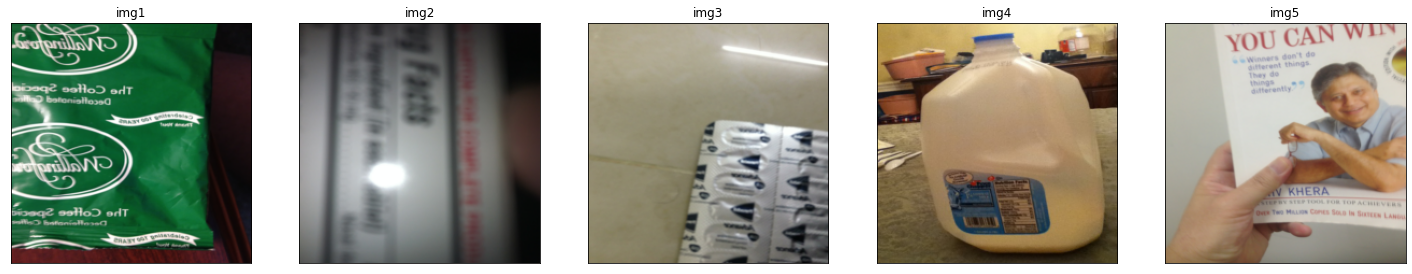

In [14]:
batch = iter(trainloader).next()
show_batch(batch, 2, 5)

## Model Description

In [0]:
# class ResnetEncoder(nn.Module):
#   def __init__(self, outsize=16):
#     super(ResnetEncoder, self).__init__()
#     # pretrained resnet model
#     resnet = models.resnet34(pretrained = True)
#     # removing classifier linear layer
#     # as we require only the features of the images
#     self.resnet = nn.Sequential(*list(resnet.children())[:-2])
#     # for variable size input images -> fixed sized output
#     self.avgPool = nn.AdaptiveAvgPool2d((outsize, outsize))

#   def forward(self, x):
#     x = self.resnet(x)
#     # x -> bs x 2048 x 7 x 7
#     x = F.relu(self.avgPool(x))
#     # x -> bs x 2048 x outsize x outsize
#     bs, feats= x.shape[0], x.shape[1]
#     x = x.view(bs, feats, -1)
#     return x.float()

In [0]:
class ImageEncoder(nn.Module):
  """
  Image encoder built using pretrained VGG19 net
    Args: outsize(dimension of model)
  """
  def __init__(self, outsize=256):
    super(ImageEncoder, self).__init__()
    # pretrained resnet model
    net = models.vgg19_bn(pretrained = True)
    # removing classifier linear layer
    # as we require only the features of the images
    self.net = nn.Sequential(*list(net.children())[:-2])
    # for variable size input images -> fixed sized output
    self.avgPool = nn.AdaptiveAvgPool2d((14, 14))
    self.linear = nn.Linear(14*14, outsize)

  def forward(self, x):
    "x: Image input"
    x = self.net(x)
    # x -> bs x 512 x 7 x 7
    x = self.avgPool(x)
    # x -> bs x 512 x 14 x 14
    bs, feats= x.shape[0], x.shape[1]
    x = x.view(bs, feats, -1)
    x = self.linear(x)
    return x.float()    

In [0]:
class PositionalEncoding(nn.Module):
  """
   -> Positional Encoding ...
    Args:
      dim (int): dimension of embedding
  """
  def __init__(self, dim, max_len=250):
    super(PositionalEncoding, self).__init__()
    pe = torch.zeros(max_len, dim)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    freq = 1/10000**(torch.arange(0., dim, 2.)/dim)
    # aranging sine and cosine terms
    pe[:, 0::2] = torch.sin(position*freq)
    pe[:, 1::2] = torch.cos(position*freq)
    self.register_buffer('pe', pe)
    
  def forward(self, sz):
    " sz: length of sequence"
    return self.pe[:sz, :]

In [0]:
class TransformerEmbedding(nn.Module):
  """
  ->Transformer embedding is built from a simple embedding
    along with a positional encoding layer

  Args:  
    d_model : dimension of embedding
    vocab_sz : size of vocabulary
    drop_p : dropout probability
    pretrained : load the weights of pretrained embedding(optional)
  """
  def __init__(self, vocab_sz, d_model, device, drop_p = 0, pretrained=False):
    self.device=device
    super(TransformerEmbedding, self).__init__()
    self.vocab_sz = vocab_sz
    self.embed = nn.Embedding(vocab_sz, d_model)
    self.pos_enc = PositionalEncoding(d_model)
    self.dropout = nn.Dropout(drop_p)
    
  # TODO: load pretrained embedding
  # def init_embed_weight(self):
  #   """ """
  #   pass
  
  def forward(self, x):
    " x: input sequence "    
    x = x.to(self.device)
    embed = self.embed(x)*math.sqrt(self.vocab_sz) + self.pos_enc(x.shape[1])
    # embed = self.embed(x) + self.pos_enc
    return self.dropout(embed)

In [0]:
class TransformerModel(nn.Module):
  """
   Transformer model for Image captioning
  Args: 
    enc_vocab_sz : vocab size of encoder
    d_model : model's dimension
    device : cuda/cpu
    enc_emb_drop : dropout probability in encoder embedding dropout layer
    n_enc_layers: number of encoder_layers in transformer encoder block
    n_dec_layers: number of decoder_layers in transformer decoder block
    n_heads: number of heads in multi head attention layer
  """
  def __init__(self, dec_vocab_sz, d_model, device, enc_emb_drop = 0.0,
               n_enc_layers=6, n_dec_layers=6, nheads=8):
    super(TransformerModel, self).__init__()

    self.pad_idx=1
    # input embedding
    # self.enc_embed = TransformerEmbedding(vocab_sz=enc_vocab_sz, d_model=d_model, drop_p=enc_emb_drop, device=device)
    # output embeddding
    self.dec_embed = TransformerEmbedding(vocab_sz=dec_vocab_sz, d_model=d_model, drop_p=0.0, device=device)
    
    # transformer encoder layer
    enc_layer = nn.TransformerEncoderLayer(d_model=d_model,
                                           nhead=nheads,
                                           dim_feedforward=2048)
    # transformer decoder layer
    dec_layer = nn.TransformerDecoderLayer(d_model=d_model,
                                           nhead=nheads,
                                           dim_feedforward=2048)

    # transformer encoder
    self.Transformer_enc = nn.TransformerEncoder(enc_layer, n_enc_layers)
    # transformer Decoder
    self.Transformer_dec = nn.TransformerDecoder(dec_layer, n_dec_layers)

    # final linear layer
    self.linear_out = nn.Linear(d_model, dec_vocab_sz)
    # softmax layer
    self.softmax = nn.Softmax(dim=-1)

  def gen_mask(self, szx, szy):
    """ 
    -> generate mask for attention layers
    -> for square mask szx == szy == seq_length
    -> for key_padding mask szx == batch_size and szy == seq_length

      for key_padding_mask, function assumes the pad_idx in vocab is zero.

      Args:
        szx : num of rows
        szy : num of columns

      Returns:
        mask (square mask / key_padding mask)
    """
    mask = (torch.triu(torch.ones(szx, szy)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

  def forward(self, inp, target):    
    """
      Args: 
        inp : input sequence(input to transformer encoder)
        target : sequence input to trasformer decoder 
    """
    # enc_embed_out = self.enc_embed(inp)
    enc_embed_out = inp
    enc_embed_out = enc_embed_out.permute(1,0,2)
    # enc_embed_out dim => (seq_length(512) x batch_size x num_features(d_model))
    # print(enc_embed_out.shape)

    dec_embed_out = self.dec_embed(target)
    dec_embed_out = dec_embed_out.permute(1, 0, 2)
    # dec_embed_out dim => (seq_length x batch_size x num_features)
    # print(dec_embed_out.shape)

    enc_out = self.Transformer_enc(src = enc_embed_out)
    # print(enc_out.shape)

    tgt_mask = self.gen_mask(dec_embed_out.shape[0], dec_embed_out.shape[0])
    tgt_mask = tgt_mask.to(device)
    # tgt_key_padding_mask = self.get_key_padding_mask

    dec_out = self.Transformer_dec(tgt=dec_embed_out,
                                   memory=enc_out,
                                   tgt_mask= tgt_mask,
                                   tgt_key_padding_mask=None)
    # output shape => seq_length x batch_size x num_features
    dec_out = dec_out.permute(1, 0, 2)
    # print(dec_out.shape)

    out = self.linear_out(dec_out)
    # return out
    # return self.softmax(out)
    return out

In [0]:
# Hyper parameters
d_model = 256                       # dimension of model/embedding
enc_vocab_sz = len(global_vocab)    # vocab size of encoder embedding
dec_vocab_sz = len(global_vocab)    # vocab size of decoder embedding

In [0]:
class CustomOptim:
    """ schedular 
    Args:
      d_model = model dimension
    type factor: (int)
    type warmup: (int)
    type optimizer : torch.nn.optim class 
    """

    def __init__(self, d_model, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = d_model
        self._rate = 0
        
    def step(self):
      "Update parameters and rate"
      self._step += 1
      rate = self.rate()
      for p in self.optimizer.param_groups:
          p['lr'] = rate
      self._rate = rate
      self.optimizer.step()
        
    def rate(self, step = None):
      if step is None:
        step = self._step
      return self.factor * \
        (self.model_size**(-0.5)*min( step**(-0.5), step*self.warmup**(-1.5)))

In [0]:
# Model intialization
imgEncoder = ImageEncoder().to(device)
transformerModel = TransformerModel(dec_vocab_sz=dec_vocab_sz,
                                    d_model=d_model,
                                    device=device,
                                    enc_emb_drop=0.1).to(device)

# for loss calculation, we'll not consider '<pad>' values in target
criterion = nn.CrossEntropyLoss(ignore_index=global_vocab.stoi['<pad>'],
                                reduction = 'sum')

In [23]:
a=(sum(p.numel() for p in imgEncoder.parameters() if p.requires_grad))
b=(sum(p.numel() for p in transformerModel.parameters() if p.requires_grad))
num_params = a+b
print(f'Total Number of Trainable parameters in complete model(imgEncoder + transformerModel): {num_params}')

Total Number of Trainable parameters in complete model(imgEncoder + transformerModel): 41961116


##Training

In [0]:
# total parameters in the model
params = list(imgEncoder.parameters())+list(transformerModel.parameters())

optimizer = CustomOptim(d_model, 1, 2000, optim.Adam(params, lr=0, betas=(0.9, 0.99)))

In [0]:
def seed_all(seed_value):
    """
     -> Function to random seed all the gpu and cpu variables to 
        regenerate the same results, at the testing time, as they were at training
    Args:
      seed_value
    """
    random.seed(seed_value) # Python
    torch.manual_seed(seed_value) # cpu vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value) # gpu variables

In [0]:
from nltk.translate.bleu_score import sentence_bleu

class BLEU:
  """ to calculate bleu score
      currenty gives result for BLEU-4 only
  """
  def __init__(self, target):
    self.target = self.get_ref(target)
    # uniform weights for n(1,2,3,4) grams.
    self.weights = [[1],
                    [0.5, 0.5],
                    [1./3, 1./3, 1./3],
                    [0.25, 0.25, 0.25, 0.25]]

  def get_ref(self, target):
    """rearrange target captions"""
    # target sequences(reference sequences)
    tgt_seqs = []
    target = target.clone().detach()
    for i in range(len(target[0])):
      s1=[]
      for b in target:
        s2=[]
        for id in b[i]:
          if id == global_vocab.stoi['<eos>']: break
          if id in [0,1,3]: continue
          s2.append(global_vocab.itos[id])
        s1.append(s2)
      tgt_seqs.append(s1)

    return tgt_seqs


  def __call__(self, preds):
    # using greedy method to get tokens
    preds = F.softmax(preds.clone().detach(), dim=1).argmax(dim=-1)
    # predicted tokens
    pred_seqs = []
    for seq in preds:
      tokens = []
      for id in seq:
        if id == global_vocab.stoi['<eos>']:  break
        tokens.append(global_vocab.itos[id])
      pred_seqs.append(tokens)

    bleu_score = []
    for i in range(len(self.target)):
      bleu_score.append(sentence_bleu(self.target[i], pred_seqs[i]))
    return np.array(bleu_score)

In [0]:
def printTime(clk, prc):
  """
  function to convert seconds time into proper format
  Args:
    clk: time in seconds
    prc: process type(train/valid)
  """
  print(f'{prc} time: {time.strftime("%H:%M:%S",time.gmtime(clk))}')

In [0]:
def saveModel(encoder, decoder, filepath, trn_loss, vld_loss):
    """
    Function to save model parameters for further use
    Args:
        encoder: image encoder model
        decoder: Decoder model
        filepath: (optional) model parameters are saved at "filepath"
        trn_loss: Training Loss
        vld_loss: validation loss calculated using CrossEntropyLoss
    """
    filepath = filepath+'_model.pth'
        
    torch.save({
            'trn_loss': trn_loss,
            'vld_loss': vld_loss,
            'encoder_sd': encoder.state_dict(),
            'decoder_sd': decoder.state_dict()
            }, filepath)
    print("Model saved at {}".format(filepath))

To Start the Training Process run the below cell. Also can change the EPOCHS and other hyperparameters

In [0]:
EPOCHS = 8
clip = 1
best_valid_loss = float('inf')
seed=53

seed_all(seed)

# list to track the losses during training
trn_loss=[]
vld_loss=[]

mbar = tqdm(range(EPOCHS), total = EPOCHS, leave=False)
for epoch in mbar:
  print(f'########## Epoch-{(epoch+1):2} ##########\n')
  ##################################
  ##           Training           ##
  ##################################
  start_time = time.time()
  imgEncoder.train()
  transformerModel.train()

  train_loss=0.

  b_loss=0    # batch_loss
  b_score=0   # bleu_score
  pbar = tqdm(enumerate(trainloader), total=len(trainloader), leave = False)
  for idx, batch in pbar:
    pbar.set_description('Training...')

    imgs = batch[0].to(device)        # images
    captions = batch[1].to(device)    # captions
    optimizer.optimizer.zero_grad()

    # image features
    img_feats = imgEncoder(imgs)
    # every image has multiple captions
    # So training for each caption seperately

    cap_loss=0
    # list of bleu_Scores
    bleu_score=0
    bleu_c = BLEU(captions)
    for i in range(len(captions)):
      # feed the captions(target), img_feats(inp) into transformer model
      
      # inout sequence is shifted by one time step
      tgt_inp = captions[i][:,1:]
      tgt_eval = captions[i][:,:-1]
      output = transformerModel(inp = img_feats,
                                target = tgt_inp)
      # get bleu score for prediction
      bleu_score = bleu_score + bleu_c(output)
      
      preds = output.view(-1, output.shape[-1])
      tgt_eval = tgt_eval.contiguous().view(-1)
      loss = criterion(input=preds, target=tgt_eval)
      cap_loss+=loss

    # bleu score of a batch prediction
    bleu_score=(bleu_score/len(captions)).mean()
    b_score+=bleu_score

    # num of non zero tokens in all captions
    num_tok = torch.sum(captions!=0)
    cap_loss/=num_tok.item()
    b_loss+=cap_loss  # update batch loss

    # calculating gradients
    cap_loss.backward()

    # clipping gradients to prevent from gradient exploding problem
    params = list(imgEncoder.parameters())+list(transformerModel.parameters())
    torch.nn.utils.clip_grad_norm_(params, clip)      
    
    # updating model parameters
    optimizer.step()

    # print stats during training
    if idx%700 == 0:
      trn_loss.append(cap_loss.item())
      print(f'trn_loss: {b_loss/(idx+1):.5f}  [BLEU_4: {b_score/(idx+1):.4f}]')

  # mean batch loss
  train_loss = b_loss/len(trainloader)
  # mean training bleu score
  trn_b_score = b_score/len(trainloader)
  train_time = time.time() - start_time



  # reset time for validation
  start_time = time.time()
  ################################
  ##         Validation         ##
  ################################
  imgEncoder.eval()
  transformerModel.eval()
  valid_loss = 0.
  b_loss=0   # batch_loss
  b_score=0  # bleu_Score
  with torch.no_grad():
    pbar = tqdm(enumerate(validloader), total=len(validloader), leave=False)
    for idx, batch in pbar:
      pbar.set_description('Validation...')
      imgs = batch[0].to(device)        # images
      captions = batch[1].to(device)    # captions

      cap_loss=0
      bleu_c = BLEU(captions)

      bleu_score = 0
      # image features
      img_feats = imgEncoder(imgs)
      for i in range(len(captions)):
        
        tgt_inp = captions[i][:,1:]
        tgt_eval = captions[i][:,:-1]
        output = transformerModel(inp=img_feats,
                                  target=tgt_inp)
        # get bleu score of the predictions
        bleu_score= bleu_score + bleu_c(output)

        # calculate loss
        preds = output.view(-1, output.shape[-1])
        tgt_eval = tgt_eval.contiguous().view(-1)
        loss = criterion(input=preds, target=tgt_eval)
        cap_loss+=loss

      # bleu score for batch
      bleu_score=(bleu_score/len(captions)).mean()
      b_score+=bleu_score

      num_tokens = torch.sum(captions!=0)
      cap_loss/=num_tokens.item()
      b_loss+=cap_loss

    # mean training loss
    valid_loss = b_loss/(len(validloader))
    # mean bleu_score of the predictions
    vld_b_score = b_score/len(validloader)
    vld_loss.append(valid_loss.item())

  # eval time
  eval_time = time.time()-start_time  
  
  # training stats
  print("\n --- Training --- \n  Loss: {:.4f} \n  BLEU_4: {:.4f}".format(
      train_loss, trn_b_score
  ))

  # validation stats
  print("\n --- Validation --- \n  Loss: {:.4f} \n  BLEU_4: {:.4f}\n".format(
      valid_loss, vld_b_score
  ))
  # print('Training Loss: {:.4f} | Validation Loss: {:.4f} | train BLEU score: {:.4f} | valid BLEU score: {:.4f}'.format(train_loss, valid_loss, trn_b_score, vld_b_score))
  # print('train BLEU score: {:.4f}')

  # save best model
  if valid_loss.item() < best_valid_loss:
    best_valid_loss = valid_loss.item()
    saveModel(imgEncoder, transformerModel, 'vizvizV01', trn_loss, vld_loss)

  printTime(train_time, 'Training')
  printTime(eval_time, 'Validation')
  print('')

########## Epoch- 1 ##########



trn_loss: 9.19915  [BLEU_4: 0.0000]
trn_loss: 4.26782  [BLEU_4: 0.3680]
trn_loss: 3.09122  [BLEU_4: 0.3676]
trn_loss: 2.49889  [BLEU_4: 0.3587]
trn_loss: 2.12984  [BLEU_4: 0.3508]



 --- Training --- 
  Loss: 2.0689 
  BLEU_4: 0.3506

 --- Validation --- 
  Loss: 0.7180 
  BLEU_4: 0.4740

Model saved at vizvizV01_model.pth
Training time: 01:08:57
Validation time: 00:11:02

########## Epoch- 2 ##########



trn_loss: 0.63760  [BLEU_4: 0.3913]


KeyboardInterrupt: ignored

In [0]:
def gen_cap(img, maxlen):
  """ 
  Function to generate Captions
  Not yet tested
  Args:
    img: image
    maxlen: maximum length of the caption
            to be genereted
  Return:
    caption: generated caption of the input image
  """
  imgEncoder.eval()
  transformerModel.eval()
  with torch.no_grad():
    image = img.unsqueeze(0).to(device)
    # display image
    plt.imshow(denorm(image.squeeze(0)))
    dec_inp = torch.ones(maxlen, dtype=torch.long).to(device)

    trgt = global_vocab.stoi['<sos>']
    dec_inp[0] = trgt
    
    # image features
    img_feats = imgEncoder(image)
    for i in range(1, maxlen):
      pred = transformerModel(inp=img_feats,
                              target=dec_inp[:i].unsqueeze(0))
      # picking the last word of the sequence generated
      pred =(pred.argmax(dim=-1))[:, -1]
      # generate word till the last <eos> word is generated
      if pred.item()==global_vocab.stoi['<eos>']: break
      dec_inp[i] = pred.item()

    caption = " ".join([global_vocab.itos[id] for id in dec_inp])
  return caption